In [2]:
import torch
import urllib
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Adversarial Attack

An adversarial attack is a method in which you attempt to deceive a neural network by misclassifying an example with the smallest change to the input. An input that can deceive the network is known as an adversarial example. Adversarial examples are counterfactual examples aimed at deceiving the model, not interpreting it.

Adversarial attacks are a critical aspect of machine learning. In certain areas of research, misclassification is not tolerable. For instance, if someone were to place a small piece of tape on a stop sign, your self-driving car might misidentify it and drive through the intersection without issue

Various techniques have been developed to create adversarial examples. The majority of these approaches aim to minimize the distance between the adversarial example and the target instance, while simultaneously altering the prediction towards the intended (adversarial) outcome. Certain techniques require access to the model gradients, which limits their utility to gradient-based models like neural networks. Conversely, other methods solely necessitate access to the prediction function, rendering them model-agnostic.

In [3]:
# Loading model
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
_ = model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:07<00:00, 32.6MB/s]


In [4]:
# preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # resize
    transforms.CenterCrop(224),  # crop the center
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize channels (RGB pixel values)
])

# for a single instance
preprocess_instance = lambda x: preprocess(x).unsqueeze(0)  # we have to reshape it as a batch

In [5]:
# download an example image
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")

def download(url, filename):
    try: 
        urllib.URLopener().retrieve(url, filename)
    except: 
        urllib.request.urlretrieve(url, filename)
        
download(url, filename)

In [6]:
input_image = Image.open(filename)
input_batch = preprocess_instance(input_image)

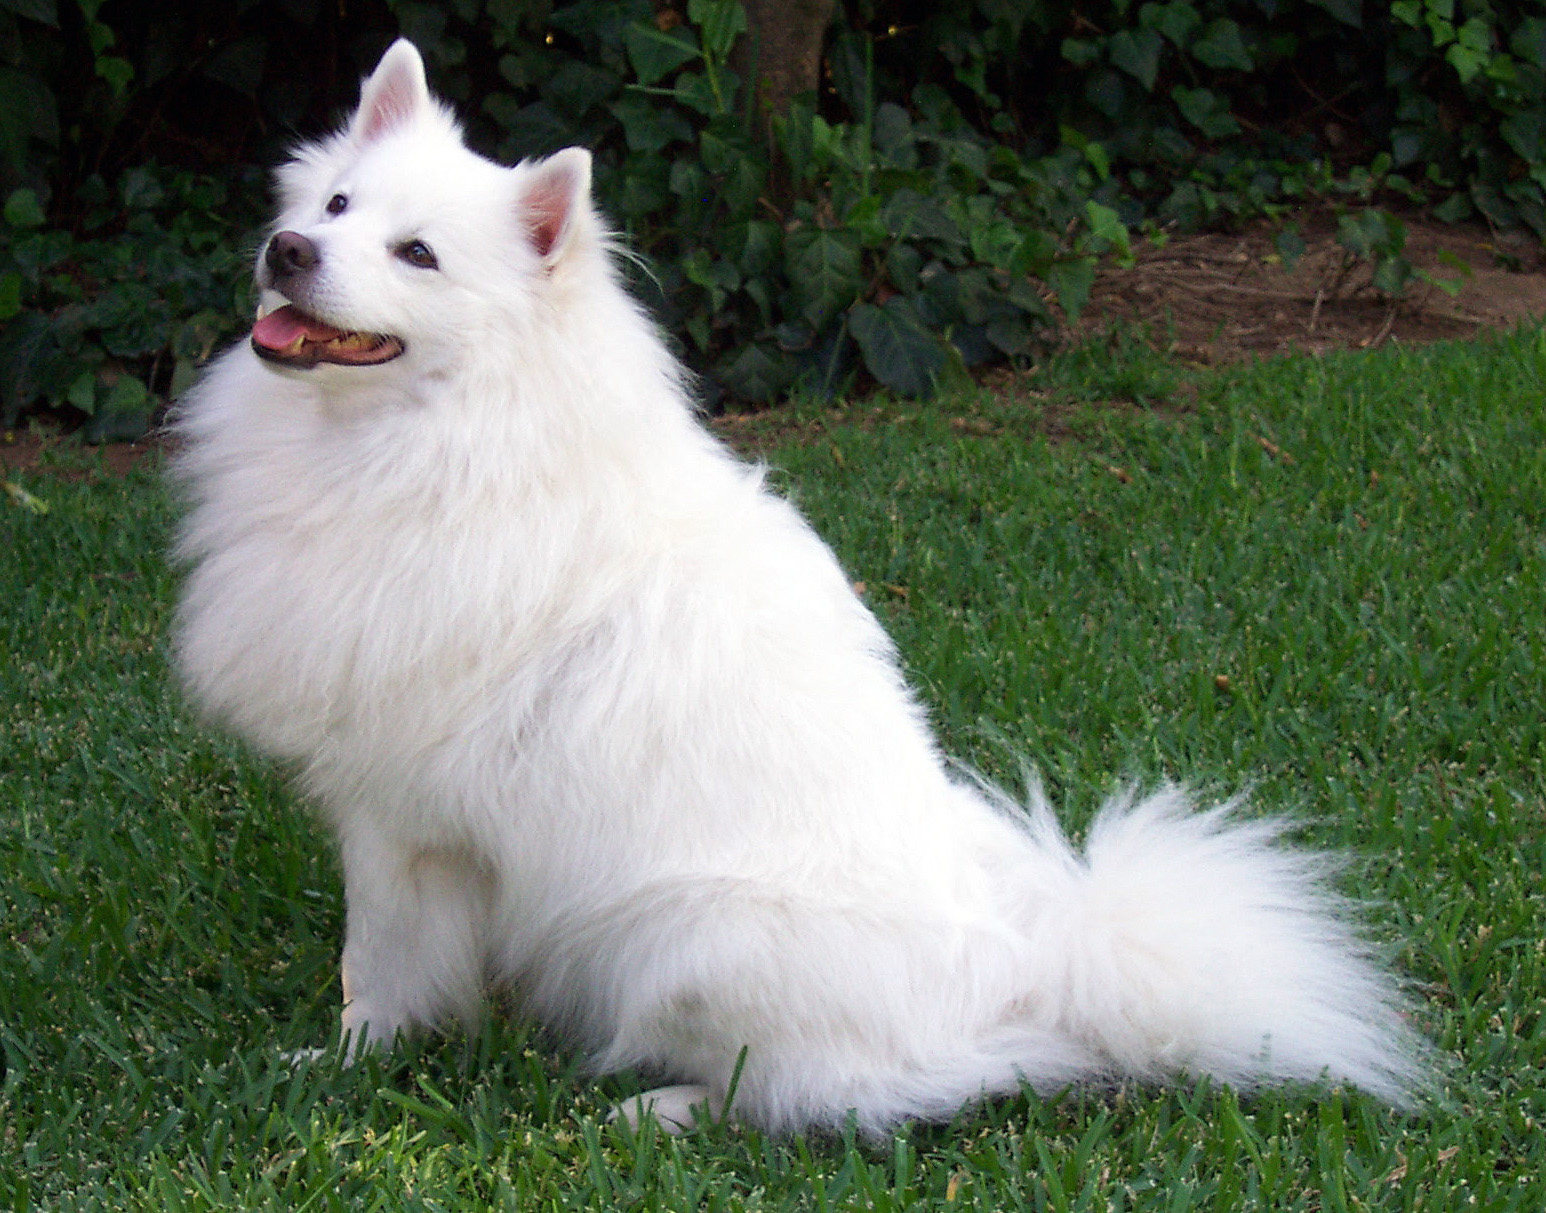

In [ ]:
display(input_image)

In [7]:
# downloading labels

download("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
with torch.no_grad():
    output = model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i, id_ in enumerate(top5_catid):
    print(f"{categories[id_]} with probablity of {top5_prob[i]}")

Samoyed with probablity of 0.7244771122932434
wallaby with probablity of 0.13937805593013763
Pomeranian with probablity of 0.05874986946582794
Angora with probablity of 0.022829852998256683
Arctic fox with probablity of 0.012450157664716244


In [ ]:
top5_catid

tensor([258, 104, 259, 332, 279])

# Intriguing properties of neural networks (Szegedy et al., 2014)

## Algorithm

In [ ]:
import torch.nn as nn

loss = nn.CrossEntropyLoss()

In [ ]:
import torch.optim as optim
import tqdm 

r = torch.rand(1, 224, 224).cuda()
r.requires_grad_()
m = model.cuda()

optimizer_adv = optim.Adam([r], lr=0.001)  # originally solved with L-BFGS

for i in tqdm.trange(3000):
    X = torch.clamp(input_batch.cuda() + r, 0, 1)  
    Y = torch.tensor([270]).cuda()

    outputs = m(X)
    _, predicted = torch.max(outputs.data, 1)

    loss_adv = r.abs().sum() + loss(outputs, Y)

    optimizer_adv.zero_grad()
    loss_adv.backward(retain_graph=True)
    optimizer_adv.step()

100%|██████████| 3000/3000 [00:25<00:00, 118.94it/s]


In [ ]:
categories[predicted.item()]

'ptarmigan'

In [ ]:
torch.nn.functional.softmax(outputs[0], dim=0)[predicted.item()].item()

0.10751891881227493

## Exmaples

In [ ]:
import torch.nn as nn
import torch.optim as optim
import tqdm 
import matplotlib as mpl


inverse_normalization = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

norm_pixels = lambda x: (x - x.min())/(x.max()-x.min())


def szegedy(image, model, iterations, adversarial_label, lr=0.001, c=1.0, device="cpu"):
    model = model.to(device)
    loss = nn.CrossEntropyLoss()
    img = preprocess_instance(image).to(device)
    
    # eval model on sample (original prediction)
    with torch.no_grad():
        output = model(img)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i, id_ in enumerate(top5_catid):
        print(f"[Original Input] {categories[id_]} ({id_}) with probablity of {top5_prob[i]}")

    # adversarial offset
    r = torch.rand(3, 224, 224).to(device)
    r.requires_grad_()

    optimizer_adv = optim.Adam([r], lr=lr)

    # optimization to find 'r' (adversarial noise)
    for i in tqdm.trange(iterations):
        # img + noise
        X = torch.clamp(img + r, 0, 1)  
        Y = torch.tensor([adversarial_label]).to(device)  # adversarial label

        # infer model with adv. example
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)

        # calculate the adversarial loss
        loss_adv = loss(outputs, Y) + c * r.abs().sum()

        # optimizer step
        optimizer_adv.zero_grad()
        loss_adv.backward(retain_graph=True)
        optimizer_adv.step()
        
    # evaluate adversarial example
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i, id_ in enumerate(top5_catid):
        print(f"[Adversarial Input] {categories[id_]} ({id_}) with probablity of {top5_prob[i]}")
        
    # vizualization
    with torch.no_grad():
        img = inverse_normalization(img[0]).cpu().detach().numpy().transpose(1, 2, 0)
        offset = r.cpu().detach().numpy().transpose(1, 2, 0)
        changed = img + offset
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title("Image")
    plt.subplot(1, 4, 2)
    plt.imshow(offset, cmap=mpl.colormaps['viridis'])
    plt.xticks([])
    plt.yticks([])
    plt.title("Noise")
    plt.subplot(1, 4, 3)
    plt.imshow(norm_pixels(offset), cmap=mpl.colormaps['viridis'])
    plt.xticks([])
    plt.yticks([])
    plt.title("Noise Normalized")
    plt.subplot(1, 4, 4)
    plt.imshow(changed)
    plt.xticks([])
    plt.yticks([])
    plt.title("Adverserial Example")
    
    return img, offset, changed

In [8]:
files = (
    ("https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01440764_tench.JPEG", "tench.jpg"),
    ("https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01514668_cock.JPEG", "cock.jpg"),
    ("https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01807496_partridge.JPEG", "partridge.jpg"),
    ("https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01784675_centipede.JPEG", "centipede.jpg")
)

files = [(download(url, file), file)[1] for url, file in files]
images = [(file, Image.open(file)) for file in files]

[Original Input] Samoyed (258) with probablity of 0.7244766354560852
[Original Input] wallaby (104) with probablity of 0.13937850296497345
[Original Input] Pomeranian (259) with probablity of 0.05874977260828018
[Original Input] Angora (332) with probablity of 0.022829795256257057
[Original Input] Arctic fox (279) with probablity of 0.012450173497200012


100%|██████████| 3000/3000 [00:25<00:00, 119.48it/s]


[Adversarial Input] ptarmigan (81) with probablity of 0.08462534844875336
[Adversarial Input] West Highland white terrier (203) with probablity of 0.04077555239200592
[Adversarial Input] Irish wolfhound (170) with probablity of 0.035045068711042404
[Adversarial Input] Arctic fox (279) with probablity of 0.03307928144931793
[Adversarial Input] Scotch terrier (199) with probablity of 0.03195232152938843


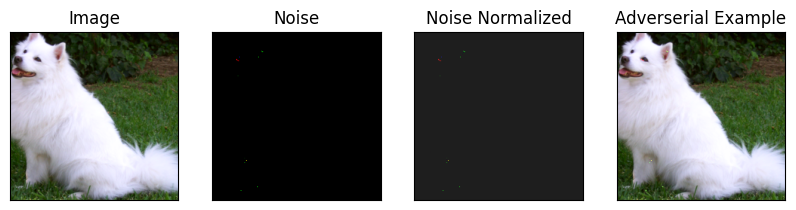

In [ ]:
_, _, _ = szegedy(input_image, model, 3000, lr=0.001, c=0.1, adversarial_label=104, device="cuda")

[Original Input] Samoyed (258) with probablity of 0.7244766354560852
[Original Input] wallaby (104) with probablity of 0.13937850296497345
[Original Input] Pomeranian (259) with probablity of 0.05874977260828018
[Original Input] Angora (332) with probablity of 0.022829795256257057
[Original Input] Arctic fox (279) with probablity of 0.012450173497200012


100%|██████████| 3000/3000 [00:25<00:00, 119.83it/s]


[Adversarial Input] ptarmigan (81) with probablity of 0.10754003375768661
[Adversarial Input] parachute (701) with probablity of 0.03869160637259483
[Adversarial Input] West Highland white terrier (203) with probablity of 0.031344518065452576
[Adversarial Input] balloon (417) with probablity of 0.025946862995624542
[Adversarial Input] Irish wolfhound (170) with probablity of 0.021714476868510246


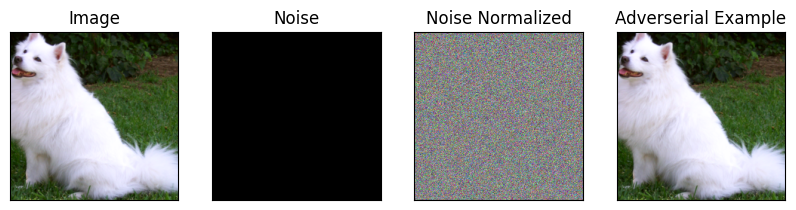

In [ ]:
_, _, _ = szegedy(input_image, model, 3000, lr=0.001, c=0.5, adversarial_label=104, device="cuda")

[Original Input] Samoyed (258) with probablity of 0.7244766354560852
[Original Input] wallaby (104) with probablity of 0.13937850296497345
[Original Input] Pomeranian (259) with probablity of 0.05874977260828018
[Original Input] Angora (332) with probablity of 0.022829795256257057
[Original Input] Arctic fox (279) with probablity of 0.012450173497200012


100%|██████████| 3000/3000 [00:25<00:00, 116.30it/s]


[Adversarial Input] ptarmigan (81) with probablity of 0.10757653415203094
[Adversarial Input] parachute (701) with probablity of 0.038707926869392395
[Adversarial Input] West Highland white terrier (203) with probablity of 0.03131714090704918
[Adversarial Input] balloon (417) with probablity of 0.02595638670027256
[Adversarial Input] Irish wolfhound (170) with probablity of 0.021687526255846024


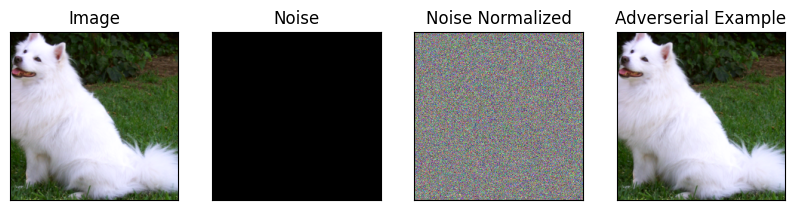

In [ ]:
_, _, _ = szegedy(input_image, model, 3000, lr=0.001, c=1, adversarial_label=104, device="cuda")

[Original Input] tench (0) with probablity of 0.9762150645256042
[Original Input] banded gecko (38) with probablity of 0.015395398251712322
[Original Input] sturgeon (394) with probablity of 0.004038751590996981
[Original Input] coho (391) with probablity of 0.001421325490809977
[Original Input] goldfish (1) with probablity of 0.0008626795024611056


100%|██████████| 3000/3000 [00:24<00:00, 120.34it/s]


[Adversarial Input] banded gecko (38) with probablity of 0.8604510426521301
[Adversarial Input] leafhopper (317) with probablity of 0.015592721290886402
[Adversarial Input] sulphur butterfly (325) with probablity of 0.014338834211230278
[Adversarial Input] axolotl (29) with probablity of 0.009195417165756226
[Adversarial Input] African chameleon (47) with probablity of 0.007522614672780037


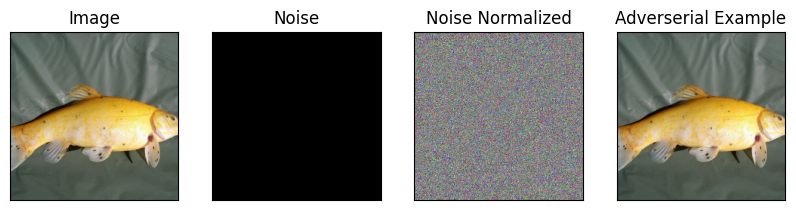

In [ ]:
_, _, _ = szegedy(images[0][1], model, 3000, lr=0.001, c=0.5, adversarial_label=38, device="cuda")

[Original Input] partridge (86) with probablity of 0.5685933828353882
[Original Input] cock (7) with probablity of 0.33193284273147583
[Original Input] drake (97) with probablity of 0.030280224978923798
[Original Input] black grouse (80) with probablity of 0.030046934261918068
[Original Input] crane (134) with probablity of 0.010588202625513077


100%|██████████| 3000/3000 [00:25<00:00, 119.09it/s]


[Adversarial Input] ski mask (796) with probablity of 0.16433846950531006
[Adversarial Input] poncho (735) with probablity of 0.1130102351307869
[Adversarial Input] bib (443) with probablity of 0.07849962264299393
[Adversarial Input] apron (411) with probablity of 0.05121120437979698
[Adversarial Input] birdhouse (448) with probablity of 0.030187996104359627


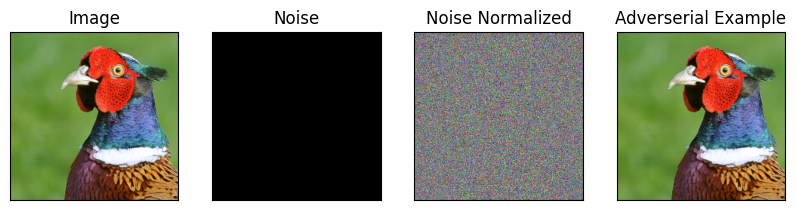

In [ ]:
_, _, _ = szegedy(images[1][1], model, 3000, lr=0.001, c=0.5, adversarial_label=796, device="cuda")

[Original Input] partridge (86) with probablity of 0.5777518153190613
[Original Input] ruffed grouse (82) with probablity of 0.42200911045074463
[Original Input] quail (85) with probablity of 0.0002387440181337297
[Original Input] limpkin (135) with probablity of 1.460577578882294e-07
[Original Input] prairie chicken (83) with probablity of 5.446268147579758e-08


100%|██████████| 3000/3000 [00:27<00:00, 108.69it/s]


[Adversarial Input] partridge (86) with probablity of 0.5923410058021545
[Adversarial Input] ruffed grouse (82) with probablity of 0.3389023244380951
[Adversarial Input] limpkin (135) with probablity of 0.04827291890978813
[Adversarial Input] quail (85) with probablity of 0.008799472823739052
[Adversarial Input] bittern (133) with probablity of 0.0067781852558255196


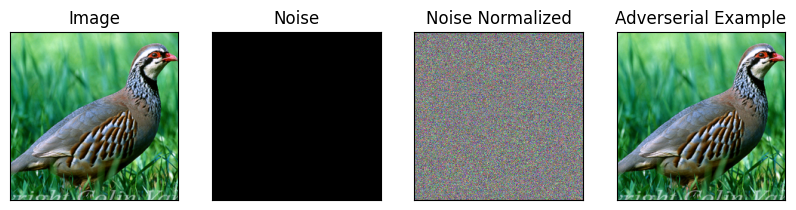

In [ ]:
_, _, _ = szegedy(images[2][1], model, 3000, lr=0.001, c=0.5, adversarial_label=82, device="cuda")

[Original Input] centipede (79) with probablity of 0.9996658563613892
[Original Input] scorpion (71) with probablity of 6.30579306744039e-05
[Original Input] cockroach (314) with probablity of 4.886625538347289e-05
[Original Input] black and gold garden spider (72) with probablity of 3.746855509234592e-05
[Original Input] spotted salamander (28) with probablity of 2.8401138479239307e-05


100%|██████████| 3000/3000 [00:24<00:00, 120.73it/s]


[Adversarial Input] centipede (79) with probablity of 0.6068019270896912
[Adversarial Input] banded gecko (38) with probablity of 0.14930129051208496
[Adversarial Input] water snake (58) with probablity of 0.06752507388591766
[Adversarial Input] common newt (26) with probablity of 0.028168130666017532
[Adversarial Input] Indian cobra (63) with probablity of 0.01465512067079544


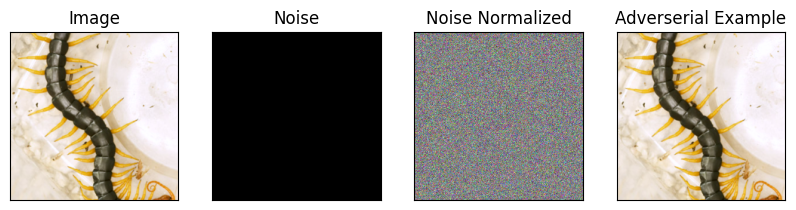

In [ ]:
_, _, _ = szegedy(images[3][1], model, 3000, lr=0.001, c=0.5, adversarial_label=71, device="cuda")

[Original Input] centipede (79) with probablity of 0.9996658563613892
[Original Input] scorpion (71) with probablity of 6.30579306744039e-05
[Original Input] cockroach (314) with probablity of 4.886625538347289e-05
[Original Input] black and gold garden spider (72) with probablity of 3.746855509234592e-05
[Original Input] spotted salamander (28) with probablity of 2.8401138479239307e-05


100%|██████████| 3000/3000 [00:25<00:00, 116.59it/s]


[Adversarial Input] banded gecko (38) with probablity of 0.6377173662185669
[Adversarial Input] centipede (79) with probablity of 0.13788239657878876
[Adversarial Input] water snake (58) with probablity of 0.03292100876569748
[Adversarial Input] common newt (26) with probablity of 0.026441194117069244
[Adversarial Input] axolotl (29) with probablity of 0.01734532229602337


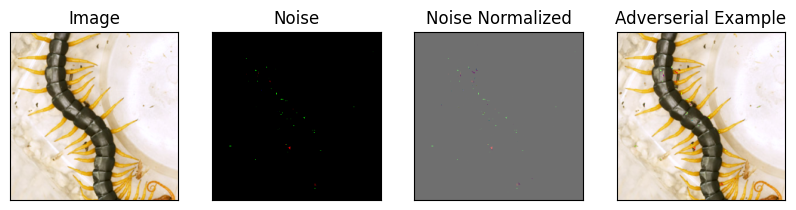

In [ ]:
_, _, _ = szegedy(images[3][1], model, 3000, lr=0.001, c=0.01, adversarial_label=38, device="cuda")

# Fast Gradient Sign Method (Goodfellow et al., 2014)

In [74]:
import torch.nn as nn
import torch.optim as optim
import tqdm 
import matplotlib as mpl


inverse_normalization = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

norm_pixels = lambda x: (x - x.min())/(x.max()-x.min())


def fsgm(image, model, adversarial_label, eps=8/255, device="cpu"):
    model = model.to(device)
    loss = nn.CrossEntropyLoss()
    img = preprocess_instance(image).to(device)
    img.requires_grad = True

    # eval model on sample
    with torch.no_grad():
        output = model(img)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i, id_ in enumerate(top5_catid):
        print(f"[Original Input] {categories[id_]} ({id_}) with probablity of {top5_prob[i]}")


    X = img
    Y = torch.tensor([adversarial_label]).to(device)

    # calculate gradients
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)

    loss_adv = -loss(outputs, Y)

    grad = torch.autograd.grad(loss_adv, img, retain_graph=False, create_graph=False)[0]
    sign = grad.sign()[0]

    adv_images = img + eps * sign
    adv_images = torch.clamp(adv_images, min=0, max=1).detach()

    # calculate probabilities for adversarial images
    outputs = model(adv_images)
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i, id_ in enumerate(top5_catid):
        print(f"[Adversarial Input] {categories[id_]} ({id_}) with probablity of {top5_prob[i]}")
        
    # for vizualization
    with torch.no_grad():
        img = inverse_normalization(img[0]).cpu().detach().numpy().transpose(1, 2, 0)  # invert the input image
        offset = sign.cpu().detach().numpy().transpose(1, 2, 0)  # adversarial noise
        changed = img + eps * offset  # adversarial image
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title("Image")
    plt.subplot(1, 4, 2)
    plt.imshow(offset, cmap=mpl.colormaps['viridis'])
    plt.xticks([])
    plt.yticks([])
    plt.title("Noise")
    plt.subplot(1, 4, 3)
    plt.imshow(norm_pixels(offset), cmap=mpl.colormaps['viridis'])
    plt.xticks([])
    plt.yticks([])
    plt.title("Noise Normalized")
    plt.subplot(1, 4, 4)
    plt.imshow(changed)
    plt.xticks([])
    plt.yticks([])
    plt.title("Adverserial Example")
    
    return img, offset, changed

[Original Input] Samoyed (258) with probablity of 0.7244766354560852
[Original Input] wallaby (104) with probablity of 0.13937850296497345
[Original Input] Pomeranian (259) with probablity of 0.05874977260828018
[Original Input] Angora (332) with probablity of 0.022829795256257057
[Original Input] Arctic fox (279) with probablity of 0.012450173497200012
[Adversarial Input] ptarmigan (81) with probablity of 0.10675638169050217
[Adversarial Input] parachute (701) with probablity of 0.05145895481109619
[Adversarial Input] balloon (417) with probablity of 0.04641776531934738
[Adversarial Input] hummingbird (94) with probablity of 0.02561001293361187
[Adversarial Input] lampshade (619) with probablity of 0.022923247888684273


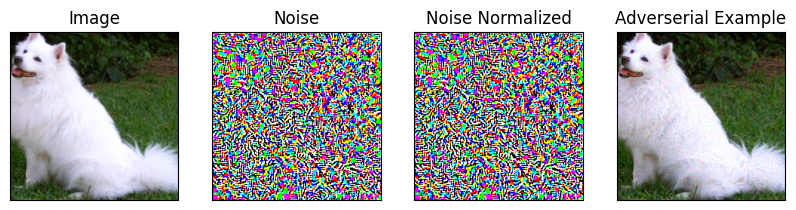

In [80]:
_, _, _ = fsgm(input_image, model, eps=8/255, adversarial_label=81, device="cuda")

[Original Input] tench (0) with probablity of 0.9762150645256042
[Original Input] banded gecko (38) with probablity of 0.015395398251712322
[Original Input] sturgeon (394) with probablity of 0.004038751590996981
[Original Input] coho (391) with probablity of 0.001421325490809977
[Original Input] goldfish (1) with probablity of 0.0008626795024611056
[Adversarial Input] banded gecko (38) with probablity of 0.8435314893722534
[Adversarial Input] leafhopper (317) with probablity of 0.01118010375648737
[Adversarial Input] sulphur butterfly (325) with probablity of 0.010677259415388107
[Adversarial Input] hair slide (584) with probablity of 0.008746613748371601
[Adversarial Input] African chameleon (47) with probablity of 0.0077413953840732574


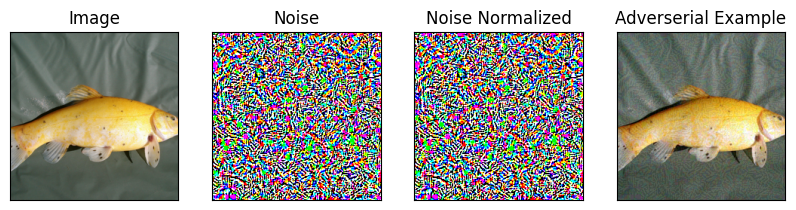

In [75]:
_, _, _ = fsgm(images[0][1], model, eps=8/255, adversarial_label=258, device="cuda")

[Original Input] partridge (86) with probablity of 0.5685933828353882
[Original Input] cock (7) with probablity of 0.33193284273147583
[Original Input] drake (97) with probablity of 0.030280224978923798
[Original Input] black grouse (80) with probablity of 0.030046934261918068
[Original Input] crane (134) with probablity of 0.010588202625513077
[Adversarial Input] poncho (735) with probablity of 0.15211151540279388
[Adversarial Input] bib (443) with probablity of 0.1262332648038864
[Adversarial Input] ski mask (796) with probablity of 0.0946991890668869
[Adversarial Input] apron (411) with probablity of 0.07352252304553986
[Adversarial Input] pajama (697) with probablity of 0.04181203991174698


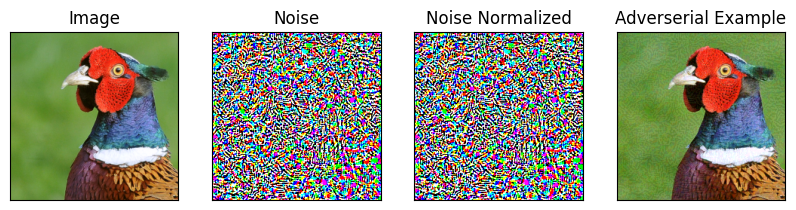

In [76]:
_, _, _ = fsgm(images[1][1], model, eps=8/255, adversarial_label=258, device="cuda")

[Original Input] partridge (86) with probablity of 0.5777518153190613
[Original Input] ruffed grouse (82) with probablity of 0.42200911045074463
[Original Input] quail (85) with probablity of 0.0002387440181337297
[Original Input] limpkin (135) with probablity of 1.460577578882294e-07
[Original Input] prairie chicken (83) with probablity of 5.446268147579758e-08
[Adversarial Input] partridge (86) with probablity of 0.5352823138237
[Adversarial Input] ruffed grouse (82) with probablity of 0.32756805419921875
[Adversarial Input] limpkin (135) with probablity of 0.09113481640815735
[Adversarial Input] bittern (133) with probablity of 0.023430949077010155
[Adversarial Input] quail (85) with probablity of 0.009583999402821064


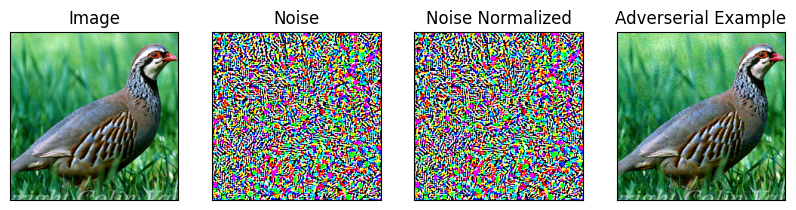

In [77]:
_, _, _ = fsgm(images[2][1], model, eps=8/255, adversarial_label=258, device="cuda")

[Original Input] centipede (79) with probablity of 0.9996658563613892
[Original Input] scorpion (71) with probablity of 6.30579306744039e-05
[Original Input] cockroach (314) with probablity of 4.886625538347289e-05
[Original Input] black and gold garden spider (72) with probablity of 3.746855509234592e-05
[Original Input] spotted salamander (28) with probablity of 2.8401138479239307e-05
[Adversarial Input] centipede (79) with probablity of 0.43220949172973633
[Adversarial Input] banded gecko (38) with probablity of 0.2136935144662857
[Adversarial Input] water snake (58) with probablity of 0.09943065792322159
[Adversarial Input] common newt (26) with probablity of 0.03922652825713158
[Adversarial Input] Indian cobra (63) with probablity of 0.021925276145339012


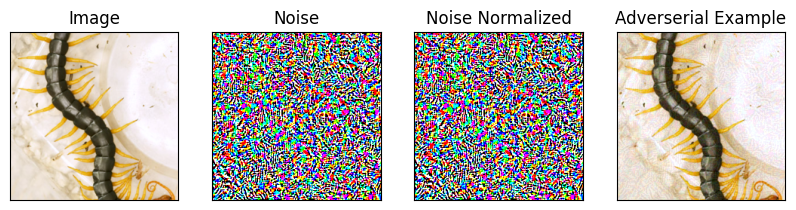

In [78]:
_, _, _ = fsgm(images[3][1], model, eps=8/255, adversarial_label=258, device="cuda")

# Projected Gradient Descent (Mardry et al., 2017)

In [65]:
import torch.nn as nn
import torch.optim as optim
import tqdm 
import matplotlib as mpl


inverse_normalization = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

norm_pixels = lambda x: (x - x.min())/(x.max()-x.min())


def pgd(image, model, iterations, adversarial_label, eps=8/255, alpha=2/255, device="cpu"):
    model = model.to(device)
    loss = nn.CrossEntropyLoss()
    img = preprocess_instance(image).to(device)
    
    # eval model on sample (original prediction)
    with torch.no_grad():
        output = model(img)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i, id_ in enumerate(top5_catid):
        print(f"[Original Input] {categories[id_]} ({id_}) with probablity of {top5_prob[i]}")

    # adversarial offset
    adv_images = img.clone().detach()

    # Starting at a uniformly random point
    adv_images = adv_images + torch.empty_like(adv_images).uniform_(-eps, eps)
    # adv_images = torch.clamp(adv_images, min=0, max=1).detach()

    target_labels = torch.tensor([adversarial_label]).to(device)

    # optimization
    for i in tqdm.trange(iterations):
        adv_images.requires_grad = True
        # infer model with adv. example
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)

        # calculate the adversarial loss
        cost = -loss(outputs, target_labels)

        # gradient
        grad = torch.autograd.grad(cost, adv_images, retain_graph=False, create_graph=False)[0]

        # step
        adv_images = adv_images.detach() + alpha * grad.sign()
        delta = torch.clamp(adv_images - img, min=-eps, max=eps)
        adv_images = img + delta
    
    # evaluate adversarial example
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i, id_ in enumerate(top5_catid):
        print(f"[Adversarial Input] {categories[id_]} ({id_}) with probablity of {top5_prob[i]}")
        
    # vizualization
    with torch.no_grad():
        img = inverse_normalization(img[0]).cpu().detach().numpy().transpose(1, 2, 0)
        offset = delta[0].cpu().detach().numpy().transpose(1, 2, 0)
        changed = inverse_normalization(adv_images[0]).cpu().detach().numpy().transpose(1, 2, 0)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title("Image")
    plt.subplot(1, 4, 2)
    plt.imshow(offset, cmap=mpl.colormaps['viridis'])
    plt.xticks([])
    plt.yticks([])
    plt.title("Noise")
    plt.subplot(1, 4, 3)
    plt.imshow(norm_pixels(offset), cmap=mpl.colormaps['viridis'])
    plt.xticks([])
    plt.yticks([])
    plt.title("Noise Normalized")
    plt.subplot(1, 4, 4)
    plt.imshow(changed)
    plt.xticks([])
    plt.yticks([])
    plt.title("Adverserial Example")
    
    return img, offset, changed

[Original Input] Samoyed (258) with probablity of 0.7244766354560852
[Original Input] wallaby (104) with probablity of 0.13937850296497345
[Original Input] Pomeranian (259) with probablity of 0.05874977260828018
[Original Input] Angora (332) with probablity of 0.022829795256257057
[Original Input] Arctic fox (279) with probablity of 0.012450173497200012


100%|██████████| 1000/1000 [00:04<00:00, 246.30it/s]


[Adversarial Input] ptarmigan (81) with probablity of 0.9999943971633911
[Adversarial Input] hen (8) with probablity of 1.5825293075977243e-06
[Adversarial Input] sulphur-crested cockatoo (89) with probablity of 1.019905994326109e-06
[Adversarial Input] albatross (146) with probablity of 6.675101644759707e-07
[Adversarial Input] hare (331) with probablity of 5.47009733509185e-07


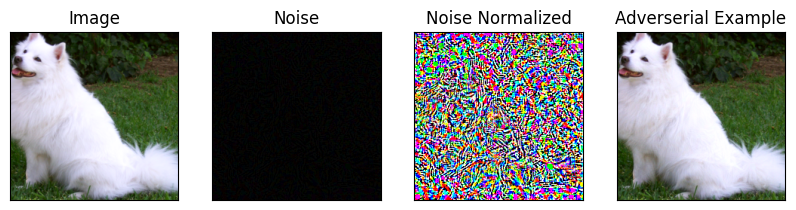

In [66]:
_, _, _ = pgd(input_image, model, 1000, adversarial_label=81, device="cuda")

[Original Input] tench (0) with probablity of 0.9762150645256042
[Original Input] banded gecko (38) with probablity of 0.015395398251712322
[Original Input] sturgeon (394) with probablity of 0.004038751590996981
[Original Input] coho (391) with probablity of 0.001421325490809977
[Original Input] goldfish (1) with probablity of 0.0008626795024611056


100%|██████████| 1000/1000 [00:04<00:00, 243.54it/s]


[Adversarial Input] Samoyed (258) with probablity of 0.9975678324699402
[Adversarial Input] projectile (744) with probablity of 0.00036029843613505363
[Adversarial Input] Great Pyrenees (257) with probablity of 0.0003330811741761863
[Adversarial Input] kuvasz (222) with probablity of 0.0002980750286951661
[Adversarial Input] Pomeranian (259) with probablity of 0.0001791663671610877


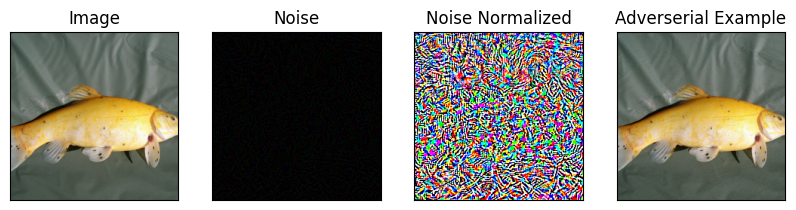

In [67]:
_, _, _ = pgd(images[0][1], model, 1000, adversarial_label=258, device="cuda")

[Original Input] partridge (86) with probablity of 0.5685933828353882
[Original Input] cock (7) with probablity of 0.33193284273147583
[Original Input] drake (97) with probablity of 0.030280224978923798
[Original Input] black grouse (80) with probablity of 0.030046934261918068
[Original Input] crane (134) with probablity of 0.010588202625513077


100%|██████████| 1000/1000 [00:04<00:00, 244.49it/s]


[Adversarial Input] golden retriever (207) with probablity of 0.12416765838861465
[Adversarial Input] Samoyed (258) with probablity of 0.07547207921743393
[Adversarial Input] drake (97) with probablity of 0.07160362601280212
[Adversarial Input] ballplayer (981) with probablity of 0.06659241020679474
[Adversarial Input] poncho (735) with probablity of 0.05254702270030975


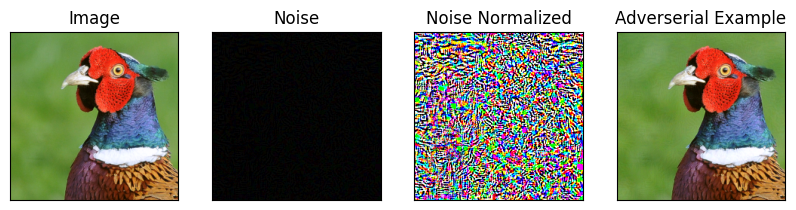

In [71]:
_, _, _ = pgd(images[1][1], model, 1000, adversarial_label=258, device="cuda")

[Original Input] partridge (86) with probablity of 0.5777518153190613
[Original Input] ruffed grouse (82) with probablity of 0.42200911045074463
[Original Input] quail (85) with probablity of 0.0002387440181337297
[Original Input] limpkin (135) with probablity of 1.460577578882294e-07
[Original Input] prairie chicken (83) with probablity of 5.446268147579758e-08


100%|██████████| 1000/1000 [00:04<00:00, 246.78it/s]


[Adversarial Input] partridge (86) with probablity of 0.6995091438293457
[Adversarial Input] ruffed grouse (82) with probablity of 0.2660118639469147
[Adversarial Input] quail (85) with probablity of 0.00824945792555809
[Adversarial Input] drake (97) with probablity of 0.007067503873258829
[Adversarial Input] prairie chicken (83) with probablity of 0.00515473447740078


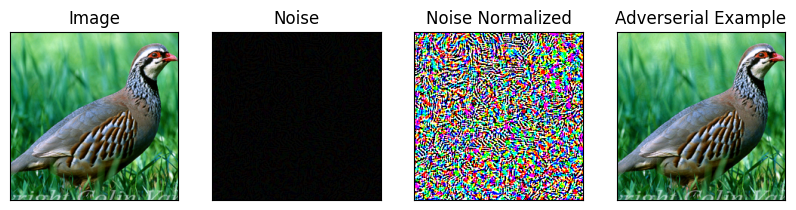

In [72]:
_, _, _ = pgd(images[2][1], model, 1000, adversarial_label=258, device="cuda")

[Original Input] centipede (79) with probablity of 0.9996658563613892
[Original Input] scorpion (71) with probablity of 6.30579306744039e-05
[Original Input] cockroach (314) with probablity of 4.886625538347289e-05
[Original Input] black and gold garden spider (72) with probablity of 3.746855509234592e-05
[Original Input] spotted salamander (28) with probablity of 2.8401138479239307e-05


100%|██████████| 1000/1000 [00:04<00:00, 244.64it/s]


[Adversarial Input] Samoyed (258) with probablity of 0.6165323257446289
[Adversarial Input] Arctic fox (279) with probablity of 0.03634144365787506
[Adversarial Input] Great Pyrenees (257) with probablity of 0.034254129976034164
[Adversarial Input] West Highland white terrier (203) with probablity of 0.029212450608611107
[Adversarial Input] kuvasz (222) with probablity of 0.025143040344119072


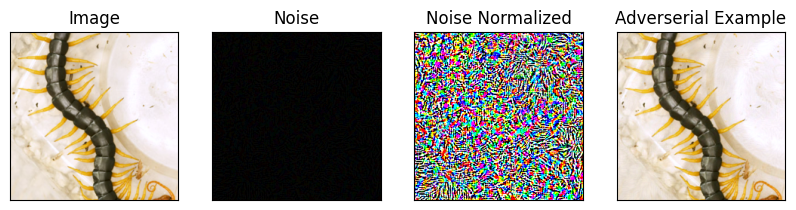

In [73]:
_, _, _ = pgd(images[3][1], model, 1000, adversarial_label=258, device="cuda")

# OnePixel (Su et al., 2019)

In [33]:
!pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.17 requires requests>=2.26, but you have requests 2.25.1 which is incompatible.
tweepy 4.13.0 requires requests<3,>=2.27.0, but you have requests 2.25.1 which is incompati

In [55]:
import torchattacks


torch.backends.cudnn.deterministic = True

inverse_normalization = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def onepixel(model, img, pixels, adversarial_label):
    atk = torchattacks.OnePixel(model, pixels=pixels)
    atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    img = preprocess_instance(img).to("cuda")

    with torch.no_grad():
        output = model(img)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i, id_ in enumerate(top5_catid):
        print(f"[Original Input] {categories[id_]} ({id_}) with probablity of {top5_prob[i]}")

    adv_img = atk(img, torch.tensor([adversarial_label]).to("cuda"))
    denormed_adv_img = inverse_normalization(adv_img[0]).detach().cpu().numpy().transpose(1, 2, 0)

    rev_img = inverse_normalization(img[0]).detach().cpu().numpy().transpose(1, 2, 0)

    with torch.no_grad():
        output = model(adv_img)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i, id_ in enumerate(top5_catid):
        print(f"[Adversarial Input] {categories[id_]} ({id_}) with probablity of {top5_prob[i]}")

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(rev_img)
    plt.xticks([])
    plt.yticks([])
    plt.title("Image")
    plt.subplot(1, 4, 2)
    plt.imshow(rev_img - denormed_adv_img, cmap=mpl.colormaps['viridis'])
    plt.xticks([])
    plt.yticks([])
    plt.title("Noise")
    plt.subplot(1, 4, 3)
    plt.imshow(norm_pixels(rev_img - denormed_adv_img), cmap=mpl.colormaps['viridis'])
    plt.xticks([])
    plt.yticks([])
    plt.title("Noise Normalized")
    plt.subplot(1, 4, 4)
    plt.imshow(denormed_adv_img)
    plt.xticks([])
    plt.yticks([])
    plt.title("Adverserial Example")

[Original Input] Samoyed (258) with probablity of 0.7244766354560852
[Original Input] wallaby (104) with probablity of 0.13937850296497345
[Original Input] Pomeranian (259) with probablity of 0.05874977260828018
[Original Input] Angora (332) with probablity of 0.022829795256257057
[Original Input] Arctic fox (279) with probablity of 0.012450173497200012
[Adversarial Input] Samoyed (258) with probablity of 0.7167782783508301
[Adversarial Input] wallaby (104) with probablity of 0.11394742876291275
[Adversarial Input] Angora (332) with probablity of 0.06402163952589035
[Adversarial Input] Pomeranian (259) with probablity of 0.04455969110131264
[Adversarial Input] Arctic fox (279) with probablity of 0.018582791090011597


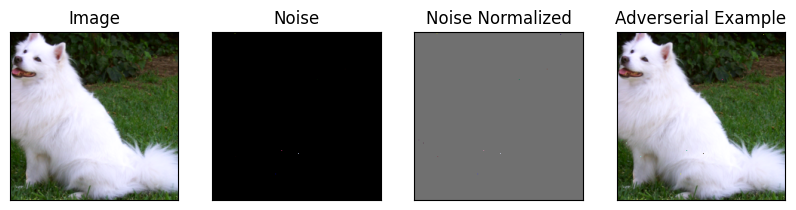

In [57]:
onepixel(model, input_image, 10, 87)

[Original Input] Samoyed (258) with probablity of 0.7244766354560852
[Original Input] wallaby (104) with probablity of 0.13937850296497345
[Original Input] Pomeranian (259) with probablity of 0.05874977260828018
[Original Input] Angora (332) with probablity of 0.022829795256257057
[Original Input] Arctic fox (279) with probablity of 0.012450173497200012


[Adversarial Input] Samoyed (258) with probablity of 0.46644216775894165
[Adversarial Input] Angora (332) with probablity of 0.32058557868003845
[Adversarial Input] wallaby (104) with probablity of 0.11969371885061264
[Adversarial Input] Pomeranian (259) with probablity of 0.031503304839134216
[Adversarial Input] hare (331) with probablity of 0.018929554149508476


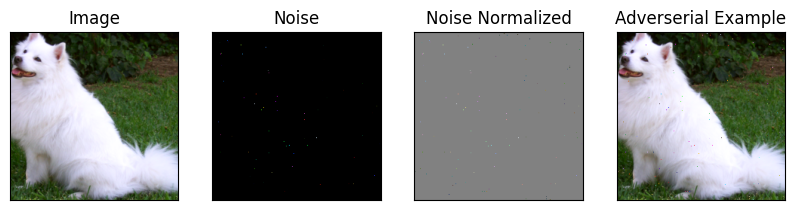

In [58]:
onepixel(model, input_image, 100, 87)

[Original Input] Samoyed (258) with probablity of 0.7244766354560852
[Original Input] wallaby (104) with probablity of 0.13937850296497345
[Original Input] Pomeranian (259) with probablity of 0.05874977260828018
[Original Input] Angora (332) with probablity of 0.022829795256257057
[Original Input] Arctic fox (279) with probablity of 0.012450173497200012


[Adversarial Input] Samoyed (258) with probablity of 0.37812307476997375
[Adversarial Input] wallaby (104) with probablity of 0.33890336751937866
[Adversarial Input] Angora (332) with probablity of 0.1246890127658844
[Adversarial Input] Pomeranian (259) with probablity of 0.033515967428684235
[Adversarial Input] Arctic fox (279) with probablity of 0.032449860125780106


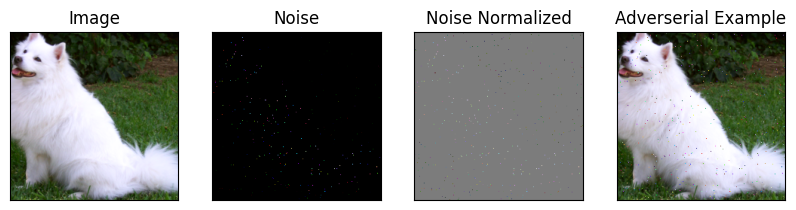

In [61]:
onepixel(model, input_image, 400, 87)